In [10]:
from tqdm import tqdm
import pandas as pd
import torchaudio
import librosa
import shutil
import json
import os

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=8, progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [11]:
def load_data(path):
    with open(path, "r", encoding="utf-8") as f:
        content = f.readlines()
        lines = [json.loads(line.strip()) for line in content]
    data = pd.DataFrame(lines)

    return data

In [12]:
in_jsonl_path = "../data/metadata/raw-jsonl/train-data-type-12.jsonl"
out_jsonl_path = "../data/metadata/filtered-jsonl/train-data-type-12.jsonl"

data = load_data(in_jsonl_path)
print(data.shape)
data.head(2)

(81731, 15)


,id,raw_text,text,utt_id,start_time,end_time,arpas,trans,phone_scores,word_scores,decisions,word_ids,utterance_score,intonation_score,fluency_score
0,3598801,Depressed,DEPRESSED,None,None,None,"[D, IH0, P, R, EH1, S, T]","[D, IH, P, R, EH, S, T]","[97, 0, 40, 99, 94, 3, 30]",[33],"[2, 0, 0, 2, 2, 0, 0]","[0, 0, 0, 0, 0, 0, 0]",33.0,0,0
1,3182408,Depressed,DEPRESSED,None,None,None,"[D, IH0, P, R, EH1, S, T]","[D, IH, P, R, EH, S, T]","[3, 0, 87, 99, 7.000000000000001, 93, 28.99999...",[30],"[0, 0, 2, 2, 0, 2, 0]","[0, 0, 0, 0, 0, 0, 0]",30.0,0,0


<Axes: >

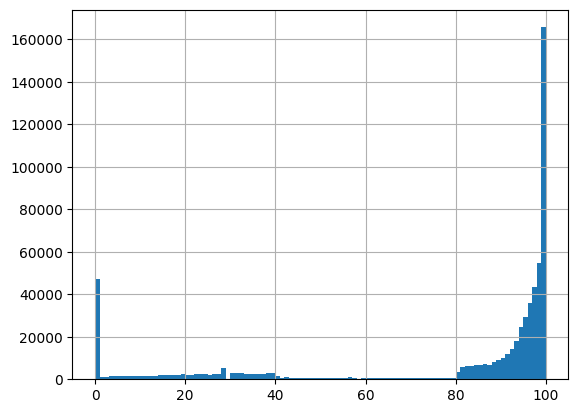

In [13]:
scores = data.apply(lambda x: x["phone_scores"], axis=1).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

In [14]:
filtered_data = []
for name, group in data.groupby("text"):
    if group.shape[0] >= 268:
        samples = group.sample(268)
        filtered_data.append(samples)
    else:
        filtered_data.append(group)

filtered_data = pd.concat(filtered_data)
filtered_data.shape

(81731, 15)

<Axes: >

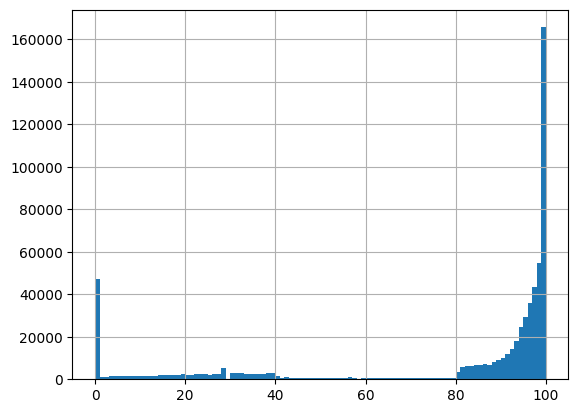

In [15]:
scores = filtered_data.apply(lambda x: x["phone_scores"], axis=1).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

<Axes: >

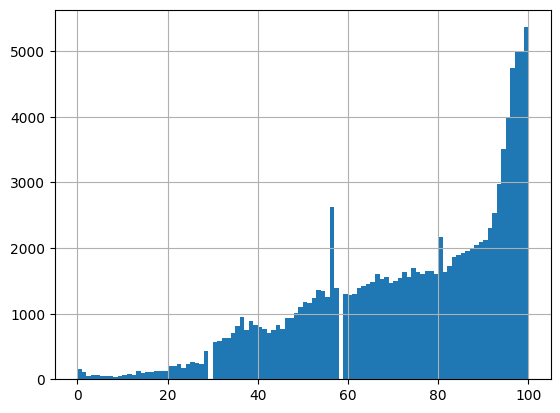

In [16]:
scores = filtered_data.apply(lambda x: x["word_scores"], axis=1).to_list()
scores = [score for sample in scores for score in sample]

pd.DataFrame(scores, columns=["score"]).score.hist(bins=100)

<Axes: >

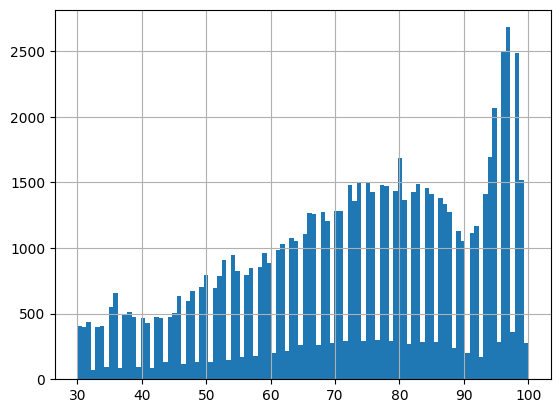

In [17]:
filtered_data.utterance_score.hist(bins=100)

In [18]:
from tqdm import tqdm
 
with open(out_jsonl_path, "w", encoding="utf-8") as f:
    for index in tqdm(filtered_data.index):
        sample = filtered_data.loc[index].to_dict()
        json_obj = json.dumps(sample)

        f.write(f'{json_obj}\n')

100%|██████████| 81731/81731 [00:02<00:00, 27585.41it/s]
